### **Load libraries**

In [33]:
import sys
sys.path.append('../src')
import pandas as pd
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import risk_kit as rk
import importlib

In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

### **Load data**

In [36]:
allocated_index = pd.read_csv('allocated_index.csv', index_col=0)
allocated_index_returns = pd.read_csv('allocated_index_returns.csv', index_col=0)

In [37]:
expected_returns = pd.read_csv('expected_returns.csv', index_col=0, header=None).iloc[:,0]
expected_covmat = pd.read_csv('expected_covmat.csv', index_col=0)

In [38]:
# Define the number of periods per year for all calculations
# 252 is an approximation for daily
# 54 for weekly
# 12 for monthly
periods_per_year = 54

### **Potential stock evolution modeled as a Brownian Motion**

In [39]:
summary_stats = rk.summary_stats(allocated_index_returns, periods_per_year=periods_per_year, riskfree_rate=0)
# Based on historical returns
index_mu = summary_stats['Annualized Return']['index']
index_sigma = summary_stats['Annualized Volatility']['index']

# Based on predicted returns
index_mu

(index_mu.round(4), index_sigma.round(4))

(0.1371, 0.1443)

In [40]:
summary_stats

,Annualized Return,Annualized Volatility,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
BVC.CL,0.116595,0.253035,0.681931,7.179835,0.044130,0.069545,0.460786,-0.356135
TERPEL.CL,0.087368,0.280660,0.559167,8.054740,0.050357,0.084848,0.311294,-0.480604
JNJ,0.101589,0.176854,-0.243544,4.840973,0.038248,0.051708,0.574424,-0.205645
SGLD.L,0.121223,0.143984,0.094824,5.100998,0.028554,0.040355,0.841924,-0.194443
JPM,0.212908,0.277673,0.069802,7.995340,0.053297,0.082295,0.766756,-0.396032
GRUBOLIVAR.CL,0.059062,0.287702,1.183502,13.790061,0.039860,0.087203,0.205289,-0.534128
index,0.137068,0.144294,-0.746103,11.607509,0.030270,0.041971,0.949927,-0.298293


In [41]:
cppi_controls = widgets.interactive(rk.show_cppi,
                                    n_scenarios=widgets.IntSlider(min=1, max=1000, step=5, value=50, description='Number of scenarios'),
                                    n_years=widgets.IntSlider(min=1, max=30, step=1, value=10, description='Number of years'),
                                    steps_per_year=widgets.IntSlider(min=1, max=252, step=1, value=12, description='Rebals/year'),
                                    mu=(-.2, .6, .01),
                                    sigma=(0, .6, .01),
                                    floor=(0, 2, .05),
                                    riskfree_rate=(0, .2, .01),
                                    y_max=widgets.IntSlider(min=0, max=100, step=1, value=100,
                                                            description="Zoom Y Axis")
                                   )
display(cppi_controls)

interactive(children=(IntSlider(value=50, description='Number of scenarios', max=1000, min=1, step=5), IntSlid…

### **Develop Drawdown-based CPPI Strategy (Constant Proportion Portfolio Insurance)**

In [42]:
# Run a backtest for the allocated index with a drawdown-based CPPI strategy
drawdown_floor = .2
rf_rate = .11
m = 5

btr = rk.run_cppi(allocated_index_returns, m=m, start=1000, riskfree_rate=rf_rate, drawdown=drawdown_floor)

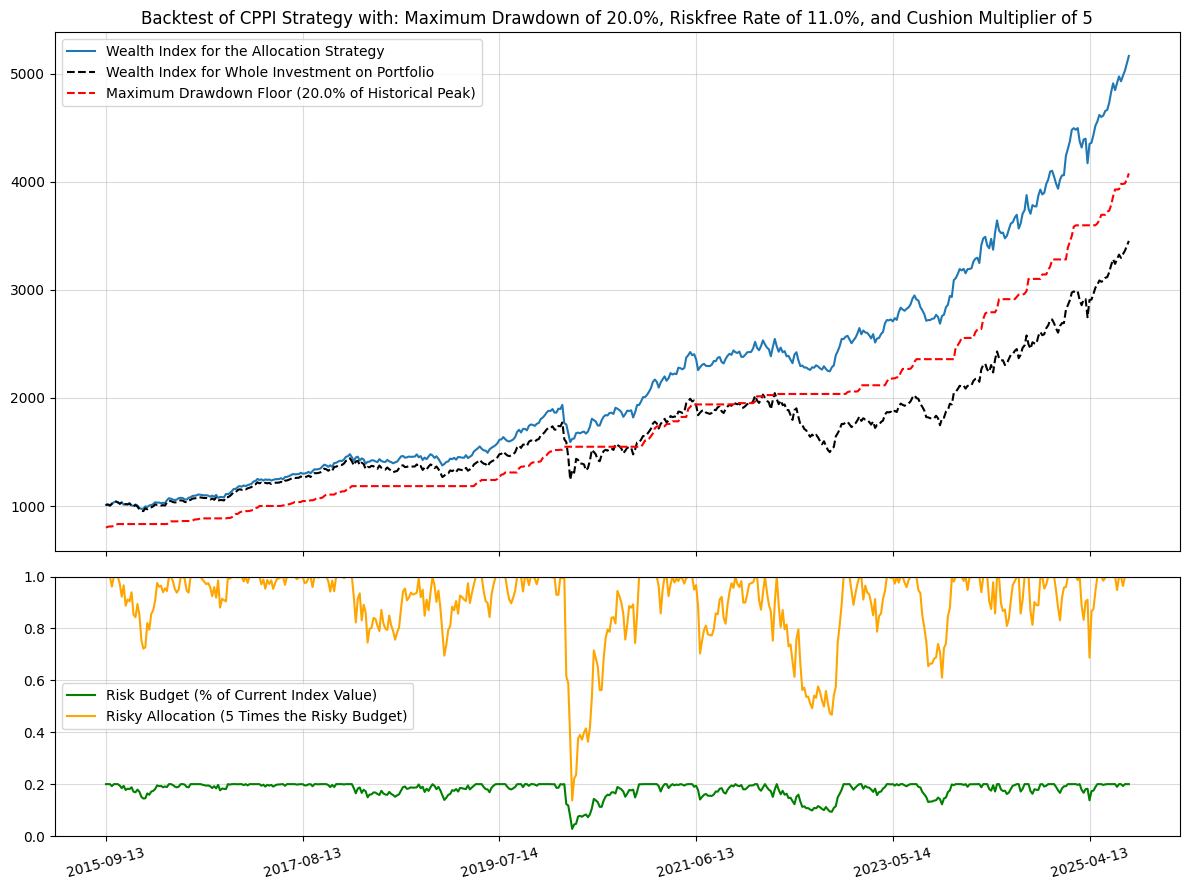

In [43]:
# Visualize the backtest of the CPPI strategy
# First subplot
fig, axes = plt.subplots(2, 1, figsize=(12, 9), gridspec_kw={'height_ratios': [2, 1]}, sharex=True)
btr['Wealth']['index'].plot(ax=axes[0], label='Wealth Index for the Allocation Strategy')
btr['Risky Wealth']['index'].plot(ax=axes[0], style='k--', label='Wealth Index for Whole Investment on Portfolio')
btr['floor']['index'].plot(ax=axes[0], color='r', linestyle='--', label=f'Maximum Drawdown Floor ({drawdown_floor*100}% of Historical Peak)')

# Second subplot
btr['Risk Budget']['index'].plot(ax=axes[1], color='g', label='Risk Budget (% of Current Index Value)')
btr['Risky Allocation']['index'].plot(ax=axes[1], color='orange', label=f'Risky Allocation ({m} Times the Risky Budget)')

axes[0].set_title(f'Backtest of CPPI Strategy with: Maximum Drawdown of {drawdown_floor*100}%, Riskfree Rate of {rf_rate*100}%, and Cushion Multiplier of {m}')

axes[0].legend()
axes[1].legend()

axes[0].grid(alpha=.45)
axes[1].grid(alpha=.45)

axes[1].set_ylim(0, 1)

plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

### **Recommended Allocation based on last week**

In [44]:
btr['Wealth']

,BVC.CL,TERPEL.CL,JNJ,SGLD.L,JPM,GRUBOLIVAR.CL,index
2015-09-13,987.654383,1085.937403,1017.741708,983.915701,1017.235942,1000.000000,1010.718211
2015-09-20,1005.699564,1070.312304,1022.779639,1013.806248,990.894185,1014.826826,1013.689455
2015-09-27,999.529659,970.839692,996.604861,1019.749787,999.561481,1014.826826,1004.038896
2015-10-04,1005.773452,1043.726523,1026.281819,1014.804407,990.236428,1032.027437,1020.587590
2015-10-11,1036.625468,1045.274255,1042.015651,1031.579072,1013.958650,1032.027437,1034.483865
...,...,...,...,...,...,...,...
2025-08-03,5579.666499,6033.400566,3528.680089,4329.000242,9958.879130,4404.630377,4930.579303
2025-08-10,5590.784583,6383.965125,3653.025163,4381.498121,9952.242968,4506.267148,4981.703860
2025-08-17,5800.501881,6596.148936,3722.785065,4320.579624,10015.995566,4581.517278,5028.971421
2025-08-24,5803.522667,6688.402768,3778.635294,4364.841039,10203.148780,4590.808317,5098.454600


In [45]:
weights = (allocated_index.iloc[0]/allocated_index['index'][0]).drop('index', axis='index')
investment = 64000000 # Current money available for investment in COP

stocks_allocation = btr['Risky Allocation']['index'][-1]*investment*weights
safe_allocation = (1 - btr['Risky Allocation']['index'][-1])*investment

C:\Users\jumar\AppData\Local\Temp\ipykernel_47732\1416061354.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  weights = (allocated_index.iloc[0]/allocated_index['index'][0]).drop('index', axis='index')
C:\Users\jumar\AppData\Local\Temp\ipykernel_47732\1416061354.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stocks_allocation = btr['Risky Allocation']['index'][-1]*investment*weights
C:\Users\jumar\AppData\Local\Temp\ipykernel_47732\1416061354.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Dat

In [46]:
# Amount allocated in risky assets
(stocks_allocation/1000).round(2)

BVC.CL            4830.51
TERPEL.CL         5798.82
JNJ               7128.12
SGLD.L           11039.27
JPM              17310.29
GRUBOLIVAR.CL    17892.99
Name: 2015-09-06, dtype: float64

In [47]:
# Amount allocated in safe assets
(safe_allocation/1000).round(2)

0.0

In [48]:
# Allocation if all budget went to the risky investment

stocks_allocation = btr['Risky Allocation']['index'][-1]*investment*weights + (1 - btr['Risky Allocation']['index'][-1])*investment*weights
(stocks_allocation/1000).round(2)

C:\Users\jumar\AppData\Local\Temp\ipykernel_47732\1100804839.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stocks_allocation = btr['Risky Allocation']['index'][-1]*investment*weights + (1 - btr['Risky Allocation']['index'][-1])*investment*weights


BVC.CL            4830.51
TERPEL.CL         5798.82
JNJ               7128.12
SGLD.L           11039.27
JPM              17310.29
GRUBOLIVAR.CL    17892.99
Name: 2015-09-06, dtype: float64